In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12,8) # default (6,4)

### Метода Грама--Шмидта и QR-разложение
Пусть $a_j$ --- $j$-й столбец матрицы $A\in \mathbb R^{m\times n}$.
Метод ортогонализации Грама--Шмидта позволяет найте [QR-разложение](https://en.wikipedia.org/wiki/QR_decomposition) матрицы $A$, то есть представить её в виде $A = QR$, где $Q\in \mathbb R^{m\times m}$ --- ортогональная, а $R\in \mathbb R^{m\times n}$ --- верхняя треугольная.

Если матрица $A$ квадратная и обратимая, то матрицы $Q$ и $R$ определены однозначно, если потребовать положительность диагональных элементов $R$.

Классический метод Грама--Шмидта представляет собой следующий алгоритм:

<img src="classic.png">

In [2]:
def cgs(A):
    Q = np.zeros_like(A)
    R = np.eye(A.shape[1])
    for j in range(0, A.shape[1]):
        V = A[:,j]
        for i in range(0, j):
            R[i,j] = Q[:,i] @ A[:,j]
            V = V - R[i,j] * Q[:,i]
        R[j,j] = np.linalg.norm(V, 2)
        Q[:,j] = V / R[j,j]
    return Q, R

Проверим, что функция `cgs` работает корректно:

In [3]:
A = np.random.randn(4,4)
A

array([[ 0.2772056 , -0.0946212 ,  0.52281854, -0.52186329],
       [ 0.78565793,  0.31738485,  0.56231014, -0.67102642],
       [ 0.48866882,  1.6298874 , -0.74609007, -1.89628671],
       [-0.97674957, -1.01986997, -0.2625482 , -0.58671515]])

In [4]:
Q,R = cgs(A)
R

array([[ 1.37365872,  1.46743808,  0.34838677, -0.74650499],
       [ 0.        ,  1.2856825 , -1.03487043, -1.2137562 ],
       [ 0.        ,  0.        ,  0.15094275, -0.51232021],
       [ 0.        ,  0.        ,  0.        ,  1.53941869]])

In [5]:
np.around(Q@Q.T, 1).astype(np.int)

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

In [6]:
np.around(Q@R - A, 1).astype(np.int)

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]])

In [7]:
np.max(np.abs(Q@R - A))

2.2204460492503131e-16

In [8]:
np.max(np.abs(Q.T @ Q - np.eye(Q.shape[1])))

1.4849232954361469e-15

### Погрешность аппроксимации матрицы R
Естественно ожидать, что при использовании метода Грама--Шмидта матрица $R$ (если она определена однозначно) будет найдена с относительной точностью порядка $\varepsilon$ (машинное эпсилон). Оказывается, что в общем случае это не так.

Рассмотрим специальную матрицу вида
$$
A = U S V
$$
где $U,V \in \mathbb R^{n\times n}$ --- ортогональные матрицы, а
$$
S = \text{diag}(2^{-1}, 2^{-2}, \dots, 2^{-n})
$$
Можно показать, что в QR-разложении такой матрицы диагональные элементы матрицы $R$ будут близки к диагональным элементам матрицы $S$.
(Подробнее см. в [Trefethen L.N., Bau D., *Numerical linear algebra*](https://lib.mipt.ru/book/300252/))

In [9]:
n = 80
U, X = np.linalg.qr(np.random.randn(n,n))
V, X = np.linalg.qr(np.random.randn(n,n))
S = np.diag(np.power(2., range(-1,-n-1,-1)))
A = U @ S @ V

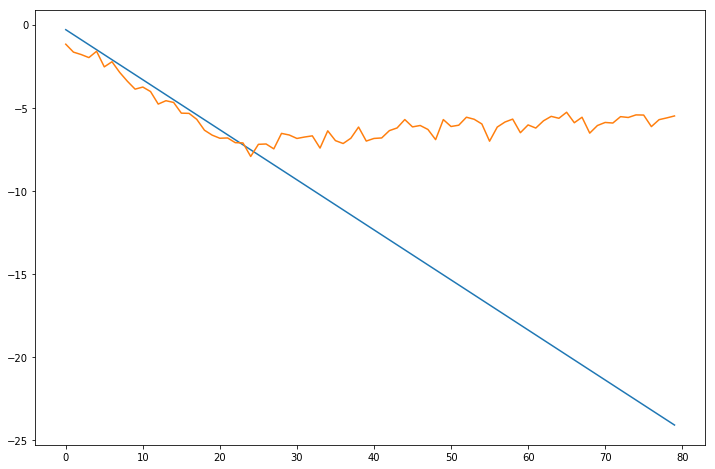

In [10]:
plt.plot(np.log10(np.power(2., range(-1,-n-1,-1))))
Q, R = cgs(A)
plt.plot(np.log10(np.diag(R)));

Из графика видно, уже при $n\approx 30$ элементы $r_{ii}$ заметно отклоняются от ожидаемых значений $2^{-i-1}$.
Это обусловлено неустойчивостью метода Грама--Шмидта.
 
### Задача
Реализуйте *модифицированный метод Грама--Шмидта*, описанный ниже, и постройте с помощью него график, аналогичный приведённому выше.

<img src="modified.png">

### Потеря ортогональности
Рассмотрим матрицу $A$ со столбцами $(1,\delta,0,0)$, $(1,0,\delta,0)$, $(1,0,0,\delta)$ и $(0,0,0,1)$.
Пусть $\delta$ настолько мало, что в машинной арифметике $1+\delta^2 = 1$.

In [11]:
delta = 2**(-52/2)/2
delta*delta + 1 == 1
A = np.array([[1,delta,0,0],[1,0,delta,0],[1,0,0,delta],[0,0,0,1]]).T
np.set_printoptions(precision=2)
A

array([[  1.00e+00,   1.00e+00,   1.00e+00,   0.00e+00],
       [  7.45e-09,   0.00e+00,   0.00e+00,   0.00e+00],
       [  0.00e+00,   7.45e-09,   0.00e+00,   0.00e+00],
       [  0.00e+00,   0.00e+00,   7.45e-09,   1.00e+00]])

In [12]:
Q, R = cgs(A)
E = np.eye(Q.shape[1])

Казалось бы, что матрица $Q$ должна быть ортогональной (с точностью до машинного эпсилон), 
то есть элементы $Q^T Q - E$ должны иметь порядок $\varepsilon \approx 10^{-16}$.
Оказывается, что это далеко не так:

In [13]:
np.max(np.abs(Q.T @ Q - E))

0.49999999999999989

**Упражнение.** Примените модифицированный метод Грама--Шмидта вместо классического.

**Упражнение.** Найдите перыве 3 столбца $Q$ на бумаге "вручную" (для обоих методов).

Отличие модифицированного метода от классического состоит в следующем:
<img src="classical_vs_modified_GS.png">